In [ ]:
#@title Imports and defaults
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import loggamma
from scipy.stats import beta
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

python 3.6.13
matplotlib 3.3.4


In [ ]:
#@title Bandit simulator and environments
class BerBandit(object):
  """Bernoulli bandit."""

  def __init__(self, mu):
    self.mu = np.copy(mu)
    self.K = self.mu.size

    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    self.rt = (np.random.rand() < self.mu).astype(float)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    return "Bernoulli bandit with arms (%s)" % \
      ", ".join("%.3f" % s for s in self.mu)


class BetaBandit(object):
  """Beta bandit."""

  def __init__(self, mu, a_plus_b=4):
    self.mu = np.copy(mu)
    self.K = self.mu.size
    self.a_plus_b = a_plus_b

    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    self.rt = \
      np.random.beta(self.a_plus_b * self.mu, self.a_plus_b * (1 - self.mu))

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    return "Beta bandit with arms (%s)" % \
      ", ".join("%.3f" % s for s in self.mu)


class GaussBandit(object):
  """Gaussian bandit."""

  def __init__(self, mu, sigma=0.5):
    self.mu = np.copy(mu)
    self.K = self.mu.size
    self.sigma = sigma

    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    self.rt = self.mu + self.sigma * np.random.randn(self.K)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    return "Gaussian bandit with arms (%s)" % \
      ", ".join("%.3f" % s for s in self.mu)


class LinBandit(object):
  """Linear bandit."""

  def __init__(self, X, theta, noise="normal", sigma=0.5):
    self.X = np.copy(X)
    self.K = self.X.shape[0]
    self.d = self.X.shape[1]
    self.theta = np.copy(theta)
    self.noise = noise
    if self.noise == "normal":
      self.sigma = sigma

    self.mu = self.X.dot(self.theta)
    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    if self.noise == "normal":
      self.rt = self.mu + self.sigma * np.random.randn(self.K)
    elif self.noise == "bernoulli":
      self.rt = (np.random.rand(self.K) < self.mu).astype(float)
    elif self.noise == "beta":
      self.rt = np.random.beta(4 * self.mu, 4 * (1 - self.mu))

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    if self.noise == "normal":
      return "Linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)
    elif self.noise == "bernoulli":
      return "Bernoulli linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)
    elif self.noise == "beta":
      return "Beta linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)


class LogBandit(object):
  """Logistic bandit."""

  def __init__(self, X, theta):
    self.X = np.copy(X)
    self.K = self.X.shape[0]
    self.d = self.X.shape[1]
    self.theta = np.copy(theta)

    self.mu = 1 / (1 + np.exp(- self.X.dot(self.theta)))
    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    self.rt = (np.random.rand(self.K) < self.mu).astype(float)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    return "Logistic bandit: %d dimensions, %d arms" % (self.d, self.K)

  @staticmethod
  def ball_env(d=3, K=10, num_env=100):
    """Arm features and theta are generated randomly in a ball."""

    env = []
    for env_id in range(num_env):
      # standard d-dimensional basis (with a bias term)
      basis = np.eye(d)
      basis[:, -1] = 1

      # arm features in a unit (d - 2)-sphere
      X = np.random.randn(K, d - 1)
      X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
      X = np.hstack((X, np.ones((K, 1))))  # bias term
      X[: basis.shape[0], :] = basis

      # parameter vector in a (d - 2)-sphere with radius 1.5
      theta = np.random.randn(d - 1)
      theta *= 1.5 / np.sqrt(np.square(theta).sum())
      theta = np.append(theta, [0])

      # create environment
      env.append(LogBandit(X, theta))
      print("%3d: %.2f %.2f | " % (env[-1].best_arm,
        env[-1].mu.min(), env[-1].mu.max()), end="")
      if (env_id + 1) % 10 == 0:
        print()

    return env


class CoBandit(object):
  """Contextual bandit with linear generalization."""

  def __init__(self, X, Theta, sigma=0.5):
    self.X = np.copy(X)  # [number of contexs] x d feature matrix
    self.Theta = np.copy(Theta)  # d x [number of arms] parameter matrix
    self.K = self.Theta.shape[1]
    self.d = self.X.shape[1]
    self.num_contexts = self.X.shape[0]
    self.sigma = sigma

    self.mu = self.X.dot(self.Theta)
    self.best_arm = np.argmax(self.mu, axis=1)

    self.randomize()

  def randomize(self):
    # choose context
    self.ct = np.random.randint(self.num_contexts)
    self.mut = self.mu[self.ct, :]

    # generate stochastic rewards
    self.rt = self.mut + self.sigma * np.random.randn(self.K)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm[self.ct]] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mut[self.best_arm[self.ct]] - self.mut[arm]

  def print(self):
    return "Contextual bandit: %d dimensions, %d arms" % (self.d, self.K)


def evaluate_one(Alg, params, env, n, period_size=1):
  """One run of a bandit algorithm."""
  alg = Alg(env, n, params)

  regret = np.zeros(n // period_size)
  for t in range(n):
    # generate state
    env.randomize()

    # take action
    arm = alg.get_arm(t)

    # update model and regret
    alg.update(t, arm, env.reward(arm))
    regret_at_t = env.regret(arm)
    regret[t // period_size] += regret_at_t

  return regret, alg


def evaluate(Alg, params, env, n=1000, period_size=1, printout=True):
  """Multiple runs of a bandit algorithm."""
  if printout:
    print("Evaluating %s" % Alg.print(), end="")
  start = time.time()

  num_exps = len(env)
  regret = np.zeros((n // period_size, num_exps))
  alg = num_exps * [None]

  dots = np.linspace(0, num_exps - 1, 100).astype(int)
  for ex in range(num_exps):
    output = evaluate_one(Alg, params, env[ex], n, period_size)
    regret[:, ex] = output[0]
    alg[ex] = output[1]

    if ex in dots:
      if printout:
        print(".", end="")
  if printout:
    print(" %.1f seconds" % (time.time() - start))

  if printout:
    total_regret = regret.sum(axis=0)
    print("Regret: %.2f +/- %.2f (median: %.2f, max: %.2f, min: %.2f)" %
      (total_regret.mean(), total_regret.std() / np.sqrt(num_exps),
      np.median(total_regret), total_regret.max(), total_regret.min()))

  return regret, alg

In [ ]:
#@title Classical algorithms for multi-armed, linear, and GLM bandits
class UCB1:
  def __init__(self, env, n, params):
    self.K = env.K
    self.crs = 1.0  # confidence region scaling

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = 1e-6 * np.ones(self.K)  # number of pulls
    self.reward = 1e-6 * np.random.rand(self.K)  # cumulative reward
    self.tiebreak = 1e-6 * np.random.rand(self.K)  # tie breaking

  def update(self, t, arm, r):
    self.pulls[arm] += 1
    self.reward[arm] += r

  def get_arm(self, t):
    # UCBs
    t += 1  # time starts at one
    ciw = self.crs * np.sqrt(2 * np.log(t))
    self.ucb = self.reward / self.pulls + \
      ciw * np.sqrt(1 / self.pulls) + self.tiebreak

    arm = np.argmax(self.ucb)
    return arm

  @staticmethod
  def print():
    return "UCB1"


class UCBV:
  def __init__(self, env, n, params):
    self.K = env.K
    self.n = n

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = np.zeros(self.K)  # number of pulls
    self.reward = np.zeros(self.K)  # cumulative reward
    self.reward2 = np.zeros(self.K)  # cumulative squared reward
    self.tiebreak = 1e-6 * np.random.rand(self.K)  # tie breaking

  def update(self, t, arm, r):
    self.pulls[arm] += 1
    self.reward[arm] += r
    self.reward2[arm] += r * r

  def get_arm(self, t):
    if t < self.K:
      # pull each arm once in the first K rounds
      self.ucb = np.zeros(self.K)
      self.ucb[t] = 1
    else:
      # UCBs
      t += 1  # time starts at one

      # from \sum_{t = 1}^n \sum_{s = 1}^t (1 / n^2) <= 1
      delta = 1.0 / np.power(self.n, 2)
      # # from \sum_{t = 1}^n \sum_{s = 1}^t (1 / t^3) <= \pi^2 / 6
      # delta = 1.0 / np.power(t, 3)

      muhat = self.reward / self.pulls
      varhat = (self.reward2 - self.pulls * np.square(muhat)) / self.pulls
      varhat = np.maximum(varhat, 0)
      self.ucb = muhat + \
        np.sqrt(2 * varhat * np.log(3 / delta) / self.pulls) + \
        3 * np.log(3 / delta) / self.pulls + \
        self.tiebreak

    arm = np.argmax(self.ucb)
    return arm

  @staticmethod
  def print():
    return "UCB-V"


class KLUCB:
  def __init__(self, env, n, params):
    self.K = env.K

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = 1e-6 * np.ones(self.K)  # number of pulls
    self.reward = 1e-6 * np.random.rand(self.K)  # cumulative reward
    self.tiebreak = 1e-6 * np.random.rand(self.K)  # tie breaking

  def UCB(self, p, N, t):
    C = (np.log(t) + 3 * np.log(np.log(t) + 1e-6)) / N

    qmin = np.minimum(np.maximum(p, 1e-6), 1 - 1e-6)
    qmax = (1 - 1e-6) * np.ones(p.size)
    for i in range(16):
      q = (qmax + qmin) / 2
      ndx = (p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))) < C
      qmin[ndx] = q[ndx]
      qmax[~ndx] = q[~ndx]

    return q

  def update(self, t, arm, r):
    if (r > 0) and (r < 1):
      r = (np.random.rand() < r).astype(float)
    self.pulls[arm] += 1
    self.reward[arm] += r

  def get_arm(self, t):
    # UCBs
    t += 1  # time starts at one
    self.ucb = \
      self.UCB(self.reward / self.pulls, self.pulls, t) + self.tiebreak

    arm = np.argmax(self.ucb)
    return arm

  @staticmethod
  def print():
    return "KL-UCB"


class TS:
  def __init__(self, env, n, params):
    self.K = env.K
    self.crs = 1.0  # confidence region scaling

    self.alpha = np.ones(self.K)  # positive observations
    self.beta = np.ones(self.K)  # negative observations

    for attr, val in params.items():
      if isinstance(val, np.ndarray):
        setattr(self, attr, np.copy(val))
      else:
        setattr(self, attr, val)

  def update(self, t, arm, r):
    if (r > 0) and (r < 1):
      r = (np.random.rand() < r).astype(float)
    self.alpha[arm] += r
    self.beta[arm] += 1 - r

  def get_arm(self, t):
    if t < self.K:
      # each arm is initially pulled once
      self.mu = np.zeros(self.K)
      self.mu[t] = 1
    else:
      # posterior sampling
      crs2 = np.square(self.crs)
      self.mu = np.random.beta(self.alpha / crs2, self.beta / crs2)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "TS"


class GaussTS:
  def __init__(self, env, n, params):
    self.K = env.K
    self.sigma = 0.5

    self.mu0 = np.zeros(self.K)
    self.sigma0 = 0.5 * np.ones(self.K)

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = np.zeros(self.K)  # number of pulls
    self.reward = np.zeros(self.K)  # cumulative reward

  def update(self, t, arm, r):
    self.pulls[arm] += 1
    self.reward[arm] += r

  def get_arm(self, t):
    if t < self.K:
      # each arm is initially pulled once
      self.mu = np.zeros(self.K)
      self.mu[t] = 1
    else:
      # posterior distribution
      sigma2 = np.square(self.sigma)
      sigma02 = np.square(self.sigma0)
      post_var = 1.0 / (1.0 / sigma02 + self.pulls / sigma2)
      post_mean = post_var * (self.mu0 / sigma02 + self.reward / sigma2)

      # posterior sampling
      self.mu = post_mean + np.sqrt(post_var) * np.random.randn(self.K)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "Gaussian TS"


class EpsilonGreedy:
  def __init__(self, env, n, params):
    self.env = env
    self.K = env.K
    self.epsilon = self.K / np.sqrt(n)
    self.crs = 1.0  # confidence region scaling

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = 1e-6 * np.ones(self.K)  # number of pulls
    self.reward = 1e-6 * np.ones(self.K)  # cumulative reward
    # self.tiebreak = 1e-6 * np.random.rand(self.K)  # tie breaking

    self.grad = np.zeros(n)
    self.metrics = np.zeros((n, 3))

    # initialize baseline
    self.is_baseline = hasattr(self, "base_Alg")
    if self.is_baseline:
      self.base_alg = self.base_Alg(env, n, self.base_params)

  def update(self, t, arm, r):
    self.pulls[arm] += 1
    self.reward[arm] += r

    best_r = self.env.rt[self.env.best_arm]
    if self.is_baseline:
      # baseline action and update
      base_arm = self.base_alg.get_arm(t)
      base_r = self.env.reward(base_arm)
      self.base_alg.update(t, base_arm, base_r)

      self.metrics[t, :] = np.asarray([r, r - best_r, r - base_r])
    else:
      self.metrics[t, :] = np.asarray([r, r - best_r, 0])

  def get_arm(self, t):
    # decision statistics
    muhat = self.reward / self.pulls
    best_arm = np.argmax(muhat)

    # probabilities of pulling arms
    eps = self.crs * self.epsilon
    p = (1 - eps) * (np.arange(self.K) == best_arm) + eps / self.K

    # pull the arm
    arm = best_arm
    if np.random.rand() < eps:
      arm = np.random.randint(self.K)

    # derivative of the probability of the pulled arm
    self.grad[t] = self.epsilon * (1 / self.K - (arm == best_arm)) / p[arm]

    return arm

  @staticmethod
  def print():
    return "e-greedy"


class Exp3:
  def __init__(self, env, n, params):
    self.env = env
    self.K = env.K
    self.crs = min(1, np.sqrt(self.K * np.log(self.K) / ((np.e - 1) * n)))

    for attr, val in params.items():
      setattr(self, attr, val)

    self.eta = self.crs / self.K
    self.reward = np.zeros(self.K)  # cumulative reward

    self.grad = np.zeros(n)
    self.metrics = np.zeros((n, 3))

    # initialize baseline
    self.is_baseline = hasattr(self, "base_Alg")
    if self.is_baseline:
      self.base_alg = self.base_Alg(env, n, self.base_params)

  def update(self, t, arm, r):
    self.reward[arm] += r / self.phat[arm]

    best_r = self.env.rt[self.env.best_arm]
    if self.is_baseline:
      # baseline action and update
      base_arm = self.base_alg.get_arm(t)
      base_r = self.env.reward(base_arm)
      self.base_alg.update(t, base_arm, base_r)

      self.metrics[t, :] = np.asarray([r, r - best_r, r - base_r])
    else:
      self.metrics[t, :] = np.asarray([r, r - best_r, 0])

  def get_arm(self, t):
    # probabilities of pulling arms
    scaled_reward = self.reward - self.reward.max()
    p = np.exp(self.eta * scaled_reward)
    p /= p.sum()
    self.phat = (1 - self.crs) * p + self.eta

    # pull the arm
    q = np.cumsum(self.phat)
    arm = np.flatnonzero(np.random.rand() * q[-1] < q)[0]

    # derivative of the probability of the pulled arm
    self.grad[t] = (1 / self.phat[arm]) * \
      ((1 - self.crs) * (p[arm] / self.K) *
      (scaled_reward[arm] - p.dot(scaled_reward)) - p[arm] + 1 / self.K)

    return arm

  @staticmethod
  def print():
    return "Exp3"


class FPL:
  def __init__(self, env, n, params):
    self.K = env.K
    self.eta = np.sqrt((np.log(self.K) + 1) / (self.K * n))

    for attr, val in params.items():
      setattr(self, attr, val)

    self.loss = np.zeros(self.K) # cumulative loss

  def update(self, t, arm, r):
    # estimate the probability of pulling the arm
    wait_time = 0
    while True:
      wait_time += 1
      ploss = self.loss + np.random.exponential(1 / self.eta, self.K)
      if np.argmin(ploss) == arm:
        break;

    self.loss[arm] += (1 - r) * wait_time

  def get_arm(self, t):
    # perturb cumulative loss
    ploss = self.loss + np.random.exponential(1 / self.eta, self.K)

    arm = np.argmin(ploss)
    return arm

  @staticmethod
  def print():
    return "FPL"


class LinBanditAlg:
  def __init__(self, env, n, params):
    self.env = env
    self.X = np.copy(env.X)
    self.K = self.X.shape[0]
    self.d = self.X.shape[1]
    self.n = n
    self.theta0 = np.zeros(self.d)
    self.sigma0 = 1.0
    self.sigma = 0.5
    self.crs = 1.0 # confidence region scaling

    for attr, val in params.items():
      setattr(self, attr, val)

    if not hasattr(self, "Sigma0"):
      self.Sigma0 = np.square(self.sigma0) * np.eye(self.d)

    # sufficient statistics
    self.Gram = np.linalg.inv(self.Sigma0)
    self.B = self.Gram.dot(self.theta0)

  def update(self, t, arm, r):
    x = self.X[arm, :]
    self.Gram += np.outer(x, x) / np.square(self.sigma)
    self.B += x * r / np.square(self.sigma)


class LinUCB(LinBanditAlg):
  def __init__(self, env, n, params):
    LinBanditAlg.__init__(self, env, n, params)

    self.cew = self.crs * self.confidence_ellipsoid_width(n)

  def confidence_ellipsoid_width(self, t):
    # Theorem 2 in Abassi-Yadkori (2011)
    # Improved Algorithms for Linear Stochastic Bandits
    delta = 1 / self.n
    L = np.amax(np.linalg.norm(self.X, axis=1))
    Lambda = 1 / np.square(self.sigma0)
    R = self.sigma
    S = np.sqrt(self.d)
    width = np.sqrt(Lambda) * S + \
      R * np.sqrt(self.d * np.log((1 + t * np.square(L) / Lambda) / delta))
    return width

  def get_arm(self, t):
    Gram_inv = np.linalg.inv(self.Gram)
    theta = Gram_inv.dot(self.B)

    # UCBs
    Gram_inv /= np.square(self.sigma)
    self.mu = self.X.dot(theta) + self.cew * \
      np.sqrt((self.X.dot(Gram_inv) * self.X).sum(axis=1))

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "LinUCB"


class LinGreedy(LinBanditAlg):
  def get_arm(self, t):
    self.mu = np.zeros(self.K)
    if np.random.rand() < 0.05 * np.sqrt(self.n / (t + 1)) / 2:
      self.mu[np.random.randint(self.K)] = np.Inf
    else:
      theta = np.linalg.solve(self.Gram, self.B)
      self.mu = self.X.dot(theta)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "Lin e-greedy"


class LinTS(LinBanditAlg):
  def update(self, t, arm, r):
    x = self.env.X[arm, :]
    self.Gram += np.outer(x, x) / np.square(self.sigma)
    self.B += x * r / np.square(self.sigma)

  def get_arm(self, t):
    Gram_inv = np.linalg.inv(self.Gram)
    thetabar = Gram_inv.dot(self.B)

    # posterior sampling
    thetatilde = np.random.multivariate_normal(thetabar,
      np.square(self.crs) * Gram_inv)
    self.mu = self.env.X.dot(thetatilde)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "LinTS"


class CoLinTS(LinBanditAlg):
  def update(self, t, arm, r):
    x = self.env.X[arm, :]
    self.Gram += np.outer(x, x) / np.square(self.sigma)
    self.B += x * r / np.square(self.sigma)

  def get_arm(self, t):
    Gram_inv = np.linalg.inv(self.Gram)
    thetabar = Gram_inv.dot(self.B)

    # posterior sampling
    thetatilde = np.random.multivariate_normal(thetabar,
      np.square(self.crs) * Gram_inv)
    self.mu = self.env.X.dot(thetatilde)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "CoLinTS"


class LogBanditAlg:
  def __init__(self, env, n, params):
    self.env = env
    self.X = np.copy(env.X)
    self.K = self.X.shape[0]
    self.d = self.X.shape[1]
    self.n = n
    self.sigma0 = 1.0
    self.crs = 1.0 # confidence region scaling
    self.crs_is_width = False

    self.irls_theta = np.zeros(self.d)
    self.irls_error = 1e-3
    self.irls_num_iter = 30

    for attr, val in params.items():
      setattr(self, attr, val)

    # sufficient statistics
    self.pos = np.zeros(self.K, dtype=int) # number of positive observations
    self.neg = np.zeros(self.K, dtype=int) # number of negative observations
    self.X2 = np.zeros((self.K, self.d, self.d)) # outer products of arm features
    for k in range(self.K):
      self.X2[k, :, :] = np.outer(self.X[k, :], self.X[k, :])

  def update(self, t, arm, r):
    self.pos[arm] += r
    self.neg[arm] += 1 - r

  def sigmoid(self, x):
    y = 1 / (1 + np.exp(- x))
    return y

  def solve(self):
    # iterative reweighted least squares for Bayesian logistic regression
    # Sections 4.3.3 and 4.5.1 in Bishop (2006)
    # Pattern Recognition and Machine Learning
    theta = np.copy(self.irls_theta)

    num_iter = 0
    while num_iter < self.irls_num_iter:
      theta_old = np.copy(theta)

      Xtheta = self.X.dot(theta)
      R = self.sigmoid(Xtheta) * (1 - self.sigmoid(Xtheta))
      pulls = self.pos + self.neg
      Gram = np.tensordot(R * pulls, self.X2, axes=([0], [0])) + \
        np.eye(self.d) / np.square(self.sigma0)
      Rz = R * pulls * Xtheta - \
        self.pos * (self.sigmoid(Xtheta) - 1) - \
        self.neg * (self.sigmoid(Xtheta) - 0)
      theta = np.linalg.solve(Gram, self.X.T.dot(Rz))

      if np.linalg.norm(theta - theta_old) < self.irls_error:
        break;
      num_iter += 1

    if num_iter == self.irls_num_iter:
      self.irls_theta = np.zeros(self.d)
    else:
      self.irls_theta = np.copy(theta)

    return theta, Gram


class LogUCB(LogBanditAlg):
  def __init__(self, env, n, params):
    LogBanditAlg.__init__(self, env, n, params)

    if not self.crs_is_width:
      self.cew = self.crs * self.confidence_ellipsoid_width(n)
    else:
      self.cew = self.crs

  def confidence_ellipsoid_width(self, t):
    # Section 4.1 in Filippi (2010)
    # Parametric Bandits: The Generalized Linear Case
    delta = 1 / self.n
    c_m = np.amax(np.linalg.norm(self.X, axis=1))
    c_mu = 0.25 # minimum derivative of the mean function
    k_mu = 0.25
    kappa = np.sqrt(3 + 2 * np.log(1 + 2 * np.square(c_m / self.sigma0)))
    R_max = 1.0
    width = (2 * k_mu * kappa * R_max / c_mu) * \
      np.sqrt(2 * self.d * np.log(t) * np.log(2 * self.d * self.n / delta))
    return width

  def get_arm(self, t):
    pulls = self.pos + self.neg
    Gram = np.tensordot(pulls, self.X2, axes=([0], [0])) + \
      np.eye(self.d) / np.square(self.sigma0)
    Gram_inv = np.linalg.inv(Gram)
    theta, _ = self.solve()

    # UCBs
    self.mu = self.sigmoid(self.X.dot(theta)) + self.cew * \
      np.sqrt((self.X.dot(Gram_inv) * self.X).sum(axis=1))

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "GLM-UCB (log)"


class UCBLog(LogBanditAlg):
  def __init__(self, env, n, params):
    LogBanditAlg.__init__(self, env, n, params)

    if not self.crs_is_width:
      self.cew = self.crs * self.confidence_ellipsoid_width(n)
    else:
      self.cew = self.crs

  def confidence_ellipsoid_width(self, t):
    # Theorem 2 in Li (2017)
    # Provably Optimal Algorithms for Generalized Linear Contextual Bandits
    delta = 1 / self.n
    sigma = 0.5
    kappa = 0.25 # minimum derivative of a constrained mean function
    width = (sigma / kappa) * \
      np.sqrt((self.d / 2) * np.log(1 + 2 * self.n / self.d) + \
      np.log(1 / delta))
    return width

  def get_arm(self, t):
    pulls = self.pos + self.neg
    Gram = np.tensordot(pulls, self.X2, axes=([0], [0])) + \
      np.eye(self.d) / np.square(self.sigma0)
    Gram_inv = np.linalg.inv(Gram)
    theta, _ = self.solve()

    # UCBs
    self.mu = self.X.dot(theta) + self.cew * \
      np.sqrt((self.X.dot(Gram_inv) * self.X).sum(axis=1))

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "UCB-GLM (log)"


class LogGreedy(LogBanditAlg):
  def __init__(self, env, n, params):
    LogBanditAlg.__init__(self, env, n, params)

    self.epsilon = 0.05

  def get_arm(self, t):
    self.mu = np.zeros(self.K)
    if np.random.rand() < self.epsilon * np.sqrt(self.n / (t + 1)) / 2:
      self.mu[np.random.randint(self.K)] = np.Inf
    else:
      theta, _ = self.solve()
      self.mu = self.sigmoid(self.X.dot(theta))

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "Log e-greedy"


class LogTS(LogBanditAlg):
  def get_arm(self, t):
    thetabar, Gram = self.solve()
    Gram_inv = np.linalg.inv(Gram)

    # posterior sampling
    thetatilde = np.random.multivariate_normal(thetabar,
      np.square(self.crs) * Gram_inv)
    self.mu = self.X.dot(thetatilde)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "GLM-TSL (log)"


class LogFPL(LogBanditAlg):
  def __init__(self, env, n, params):
    self.a = 1.0

    LogBanditAlg.__init__(self, env, n, params)

  def solve(self):
    # normal noise perturbation
    pulls = self.pos + self.neg
    z = self.a * np.sqrt(pulls) * \
      np.minimum(np.maximum(np.random.randn(self.K), -6), 6)

    # iterative reweighted least squares for Bayesian logistic regression
    # Sections 4.3.3 and 4.5.1 in Bishop (2006)
    # Pattern Recognition and Machine Learning
    theta = np.copy(self.irls_theta)

    num_iter = 0
    while num_iter < self.irls_num_iter:
      theta_old = np.copy(theta)

      Xtheta = self.X.dot(theta)
      R = self.sigmoid(Xtheta) * (1 - self.sigmoid(Xtheta))
      Gram = np.tensordot(R * pulls, self.X2, axes=([0], [0])) + \
        np.eye(self.d) / np.square(self.sigma0)
      Rz = R * pulls * Xtheta - \
        (pulls * self.sigmoid(Xtheta) - (self.pos + z))
      theta = np.linalg.solve(Gram, self.X.T.dot(Rz))

      if np.linalg.norm(theta - theta_old) < self.irls_error:
        break;
      num_iter += 1

    if num_iter == self.irls_num_iter:
      self.irls_theta = np.zeros(self.d)
    else:
      self.irls_theta = np.copy(theta)

    return theta, Gram

  def get_arm(self, t):
    self.mu = np.zeros(self.K)
    if t < self.d:
      self.mu[t] = np.Inf
    else:
      # history perturbation
      theta, _ = self.solve()
      self.mu = self.sigmoid(self.X.dot(theta))

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "GLM-FPL (log)"

OracleTS: 80.4 +/- 8.0
TS: 371.1 +/- 37.1
MetaTS: 183.4 +/- 18.3
MetaTSx: 221.7 +/- 22.2
MetaTSd: 178.7 +/- 17.9


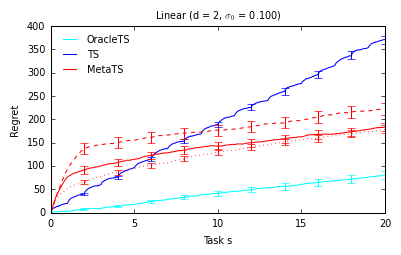

OracleTS: 168.3 +/- 16.8
TS: 371.0 +/- 37.1
MetaTS: 221.5 +/- 22.2
MetaTSx: 265.1 +/- 26.5
MetaTSd: 244.4 +/- 24.4


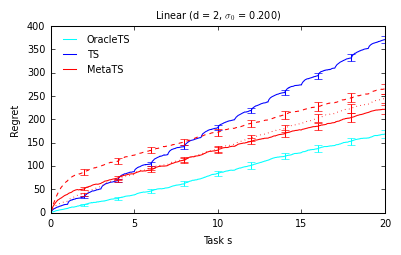

OracleTS: 299.8 +/- 30.0
TS: 358.3 +/- 35.8
MetaTS: 319.7 +/- 32.0
MetaTSx: 325.3 +/- 32.5
MetaTSd: 331.5 +/- 33.2


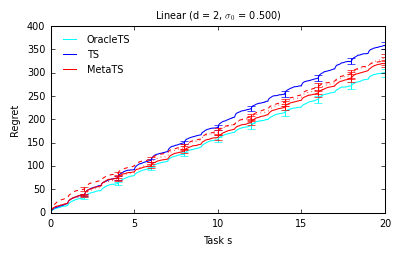

OracleTS: 104.9 +/- 10.5
TS: 729.1 +/- 72.9
MetaTS: 332.0 +/- 33.2
MetaTSx: 393.1 +/- 39.3
MetaTSd: 309.7 +/- 31.0


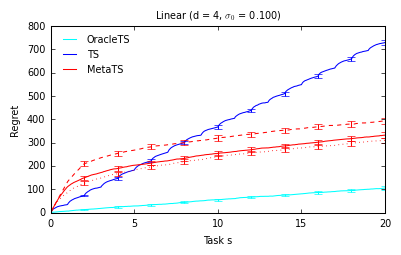

OracleTS: 274.8 +/- 27.5
TS: 749.4 +/- 74.9
MetaTS: 414.8 +/- 41.5
MetaTSx: 484.9 +/- 48.5
MetaTSd: 412.4 +/- 41.2


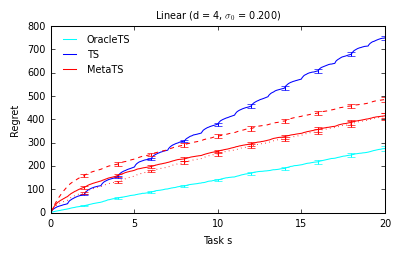

OracleTS: 578.0 +/- 57.8
TS: 713.2 +/- 71.3
MetaTS: 632.6 +/- 63.3
MetaTSx: 652.2 +/- 65.2
MetaTSd: 635.1 +/- 63.5


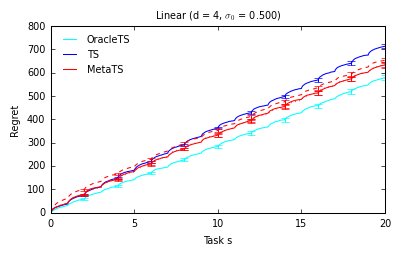

OracleTS: 122.9 +/- 12.3
TS: 1267.5 +/- 126.8
MetaTS: 545.7 +/- 54.6
MetaTSx: 617.5 +/- 61.8
MetaTSd: 516.6 +/- 51.7


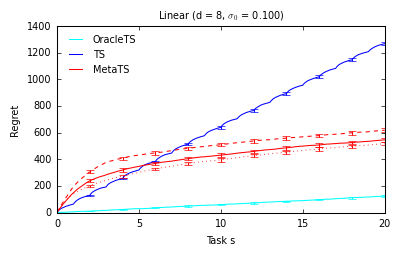

OracleTS: 344.9 +/- 34.5
TS: 1268.5 +/- 126.8
MetaTS: 670.7 +/- 67.1
MetaTSx: 729.3 +/- 72.9
MetaTSd: 634.3 +/- 63.4


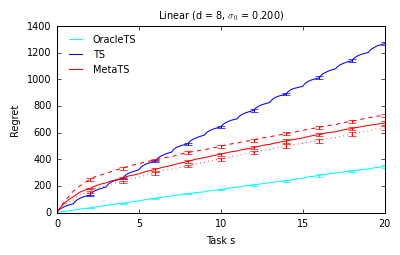

OracleTS: 911.7 +/- 91.2
TS: 1233.7 +/- 123.4
MetaTS: 1062.7 +/- 106.3
MetaTSx: 1094.7 +/- 109.5
MetaTSd: 1049.9 +/- 105.0


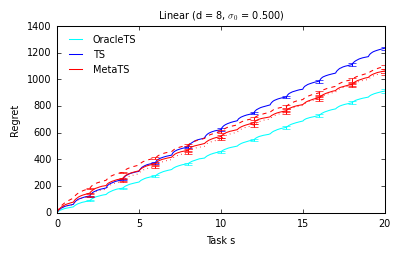

In [ ]:
# linear bandit
algs = [
  ("LinTS", 1, "cyan", "-", "OracleTS"),
  ("LinTS", 1, "blue", "-", "TS"),
  ("LinTS", 1, "red", "-", "MetaTS"),
  ("LinTS", 3, "red", "--", "MetaTSx"),  # MetaTS with 3x wider meta-prior
  ("LinTS", 0.333, "red", ":", "MetaTSd")]  # MetaTS with 3x narrower meta-prior
num_runs = 100
num_tasks = 20
n = 200

step = np.arange(1, n * num_tasks + 1) / n
sube = (step.size // 10) * np.arange(1, 11) - 1

for d in [2, 4, 8]:
  K = 5 * d
  for sigma_0_scale in [0.1, 0.2, 0.5]:
    # meta-prior parameters
    mu_q = np.zeros(d)
    sigma_q = 0.5 * np.ones(d)
    # prior parameters
    sigma_0 = sigma_0_scale * np.ones(d)
    # reward noise
    sigma = 1.0

    plt.figure(figsize=(4, 2.5))

    alg_num = 0
    for alg in algs:
      regret = np.zeros((num_tasks * n, num_runs))

      for run in range(num_runs):
        # true prior
        mu_star = mu_q + sigma_q * np.random.randn(d)

        # potential meta-prior misspecification
        sigma_q_alg = alg[1] * sigma_q 

        # incrementally updated statistics
        mu_inc = np.diag(1.0 / np.square(sigma_q_alg)).dot(mu_q)
        Lambda_inc = np.diag(1.0 / np.square(sigma_q_alg))

        # initial meta-posterior
        mu_hat = np.linalg.inv(Lambda_inc).dot(mu_inc)
        Sigma_hat = np.linalg.inv(Lambda_inc)

        for task in range(num_tasks):
          # sample problem instance from N(\mu_*, \sigma_0^2 I_d)
          theta = mu_star + sigma_0 * np.random.randn(d)
          X = np.random.rand(K, d) - 0.5
          X /= np.linalg.norm(X, axis=-1)[:, np.newaxis]
          env = LinBandit(X, theta, sigma=sigma)

          # task prior
          Sigma_q = np.diag(np.square(sigma_q))
          Sigma_0 = np.diag(np.square(sigma_0))
          if alg_num == 0:
            # OracleTS
            mu_task = np.copy(mu_star)
            Sigma_task = np.copy(Sigma_0)
          elif alg_num == 1:
            # TS
            mu_task = np.copy(mu_q)
            Sigma_task = Sigma_0 + Sigma_q
          elif alg_num >= 2:
            if alg[-1].startswith("Meta"):
              # MetaTS
              mu_tilde = np.random.multivariate_normal(mu_hat, Sigma_hat)
              mu_task = np.copy(mu_tilde)
              Sigma_task = np.copy(Sigma_0)
            else:
              # AdaTS
              mu_task = np.copy(mu_hat)
              Sigma_task = Sigma_0 + Sigma_hat

          # evaluate on a sampled problem instance
          alg_class = globals()[alg[0]]
          alg_params = {
            "theta0": mu_task,
            "Sigma0": Sigma_task,
            "sigma": sigma}
          task_regret, logs = evaluate(
            alg_class, alg_params, [env], n, printout=False)
          regret[task * n : (task + 1) * n, run] += task_regret.flatten()

          # meta-posterior update
          if alg_num >= 2:
            # subtract priors, which are added in LinTS
            M = np.linalg.inv(Sigma_task)
            St = logs[0].Gram - M
            ct = logs[0].B - M.dot(mu_task)

            # incremental update
            M = np.linalg.inv(np.eye(d) / np.square(sigma_0) + St)
            mu_inc += ct - St.dot(M).dot(ct)
            Lambda_inc += St - St.dot(M).dot(St)

            mu_hat = np.linalg.inv(Lambda_inc).dot(mu_inc)
            Sigma_hat = np.linalg.inv(Lambda_inc)

      cum_regret = regret.cumsum(axis=0)
      plt.plot(step, cum_regret.mean(axis=1),
        alg[2], dashes=linestyle2dashes(alg[3]),
        label=alg[4] if alg[1] == 1 else "")
      plt.errorbar(step[sube], cum_regret[sube, :].mean(axis=1),
        cum_regret[sube, :].std(axis=1) / np.sqrt(cum_regret.shape[1]),
        fmt="none", ecolor=alg[2])

      print("%s: %.1f +/- %.1f" % (alg[4],
        cum_regret[-1, :].mean(),
        cum_regret[-1, :].mean() / np.sqrt(cum_regret.shape[1])))

      alg_num += 1

    plt.title(r"Linear (d = %d, $\sigma_0$ = %.3f)" % (d, sigma_0_scale))
    plt.xlabel("Task s")
    plt.ylabel("Regret")
    plt.ylim(bottom=0)
    plt.legend(loc="upper left", frameon=False)

    plt.tight_layout()
    plt.show()